# Dataset Visualization and Preprocessing Steps

## Import Libraries and Configure Warnings

In [1]:
import warnings

import nibabel as nib
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from utils import visualize_mri_slices, to_categorical

warnings.filterwarnings('ignore')

## Define Dataset Directory

In [2]:
TRAIN_DIR = "data/training_data/"

## Initialize Min-Max Scaler

In [3]:
scalar = MinMaxScaler()

## Load and Normalize MRI Modalities

In [4]:
test_img_flair = nib.load(TRAIN_DIR + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()

In [5]:
test_img_flair.shape

(240, 240, 155)

In [6]:
test_img_flair.max()

np.float64(1854.603271484375)

In [7]:
test_img_flair.reshape(-1, test_img_flair.shape[-1]).shape

(57600, 155)

In [8]:
test_img_flair = scalar.fit_transform(test_img_flair.reshape(-1, test_img_flair.shape[-1])).reshape(
    test_img_flair.shape)

In [9]:
test_img_flair.max()

np.float64(1.0)

In [10]:
test_img_t1 = nib.load(TRAIN_DIR + "BraTS20_Training_355/BraTS20_Training_355_t1.nii").get_fdata()
test_img_t1 = scalar.fit_transform(test_img_t1.reshape(-1, test_img_t1.shape[-1])).reshape(test_img_t1.shape)

In [11]:
test_img_t1ce = nib.load(TRAIN_DIR + "BraTS20_Training_355/BraTS20_Training_355_t1ce.nii").get_fdata()
test_img_t1ce = scalar.fit_transform(test_img_t1ce.reshape(-1, test_img_t1ce.shape[-1])).reshape(test_img_t1ce.shape)

In [12]:
test_img_t2 = nib.load(TRAIN_DIR + "BraTS20_Training_355/BraTS20_Training_355_t2.nii").get_fdata()
test_img_t2 = scalar.fit_transform(test_img_t2.reshape(-1, test_img_t2.shape[-1])).reshape(test_img_t2.shape)

## Load and Preprocess Segmentation Mask

> **Label Mapping:
> - Label 0 → Background
> - Label 1 → NCR/NET (Necrotic Core)
> - Label 2 → Edema
> - Label 3 → Enhancing Tumor
> - Label 4 → Needs to be changed to 3 (Enhancing Tumor)

In [13]:
test_mask = nib.load(TRAIN_DIR + "BraTS20_Training_355/BraTS20_Training_355_seg.nii").get_fdata()
test_mask = test_mask.astype(np.uint8)

In [14]:
print(np.unique(test_mask))
test_mask[test_mask == 4] = 3
print(np.unique(test_mask))

[0 1 2 4]
[0 1 2 3]


## Visualize a Random MRI Slice

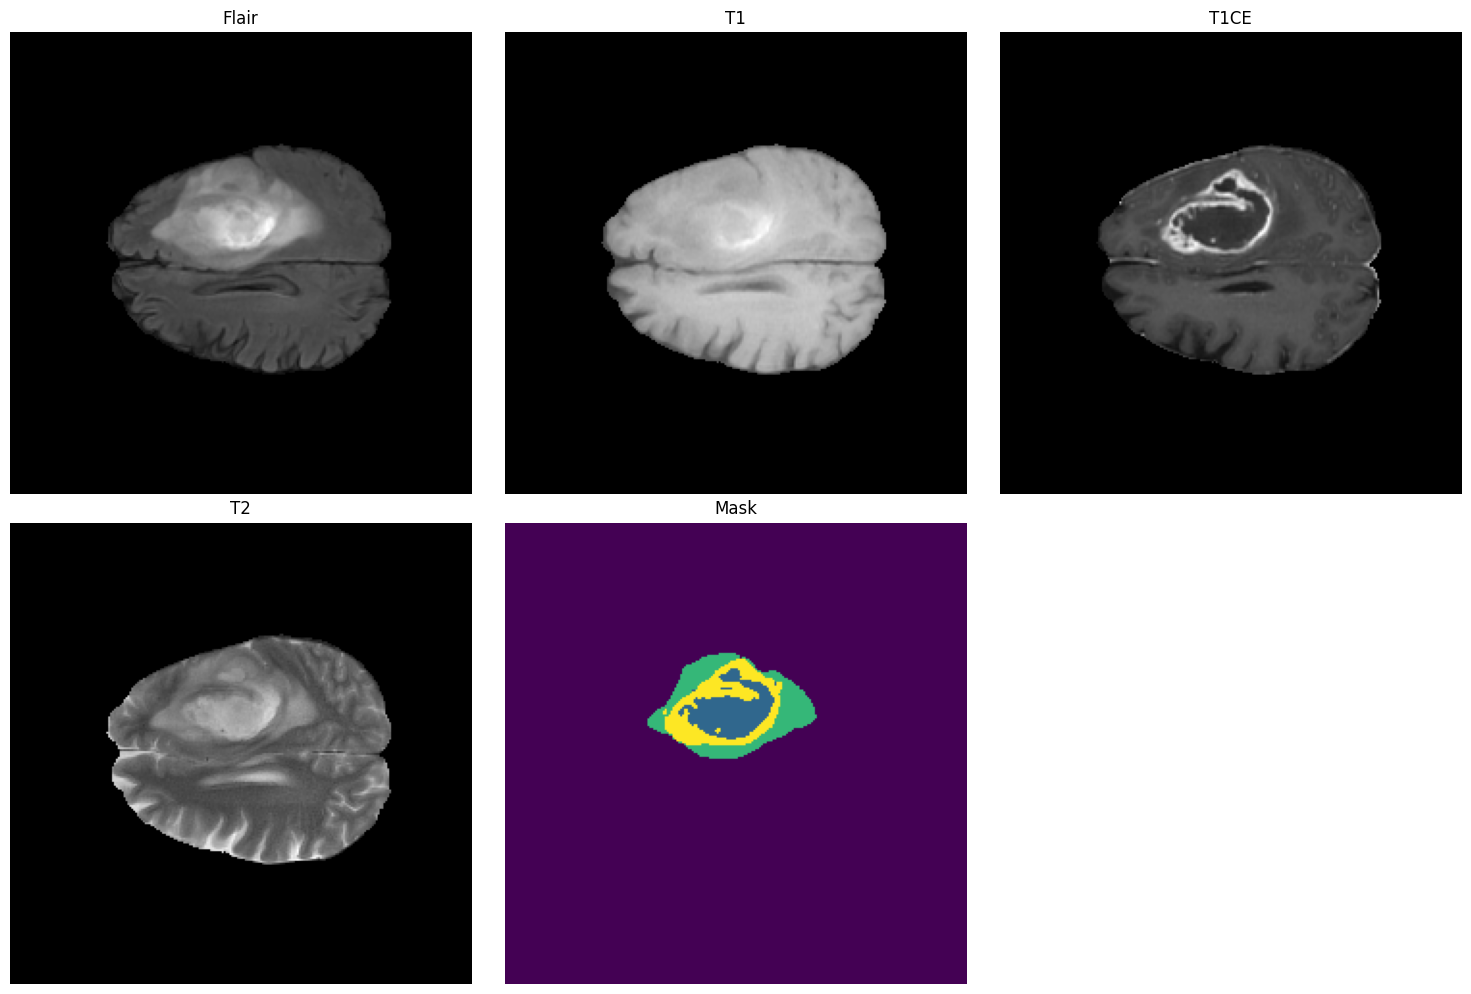

In [15]:
import random
import matplotlib.pyplot as plt

random.seed(0)
n_slice = random.randint(0, test_mask.shape[-1] - 1)

# Plot images
plt.figure(figsize=(15, 10))

images = [test_img_flair, test_img_t1, test_img_t1ce, test_img_t2, test_mask]
titles = ['Flair', 'T1', 'T1CE', 'T2', 'Mask']

for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(2, 3, i + 1)
    if title == 'Mask':
        plt.imshow(image[:, :, n_slice])
    else:
        plt.imshow(image[:, :, n_slice], cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Combine Selected Modalities into a Multi-Channel Image
The combined image will have 3 channels: **FLAIR**, **T1CE**, and **T2**.

In [16]:
combined_x = np.stack([test_img_flair, test_img_t1ce, test_img_t2], axis=3)
combined_x.shape

(240, 240, 155, 3)

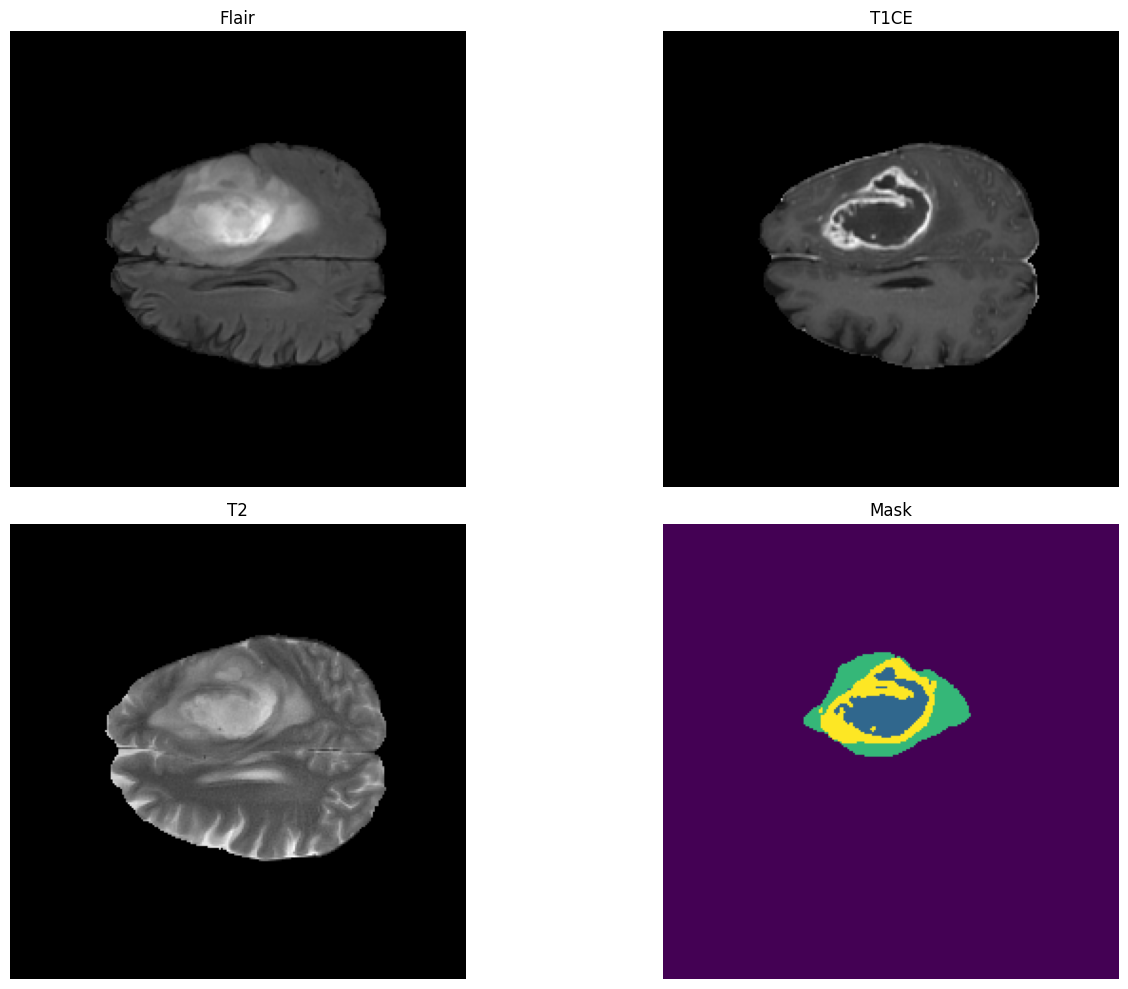

In [17]:
visualize_mri_slices(combined_x, test_mask, seed=0)

### Crop unnecessary regions and create a `128x128x128` volume

In [18]:
combined_x = combined_x[56:184, 56:184, 13:141]

In [19]:
test_mask = test_mask[56:184, 56:184, 13:141]

In [20]:
combined_x[:, :, :, 1].shape, test_mask.shape

((128, 128, 128), (128, 128, 128))

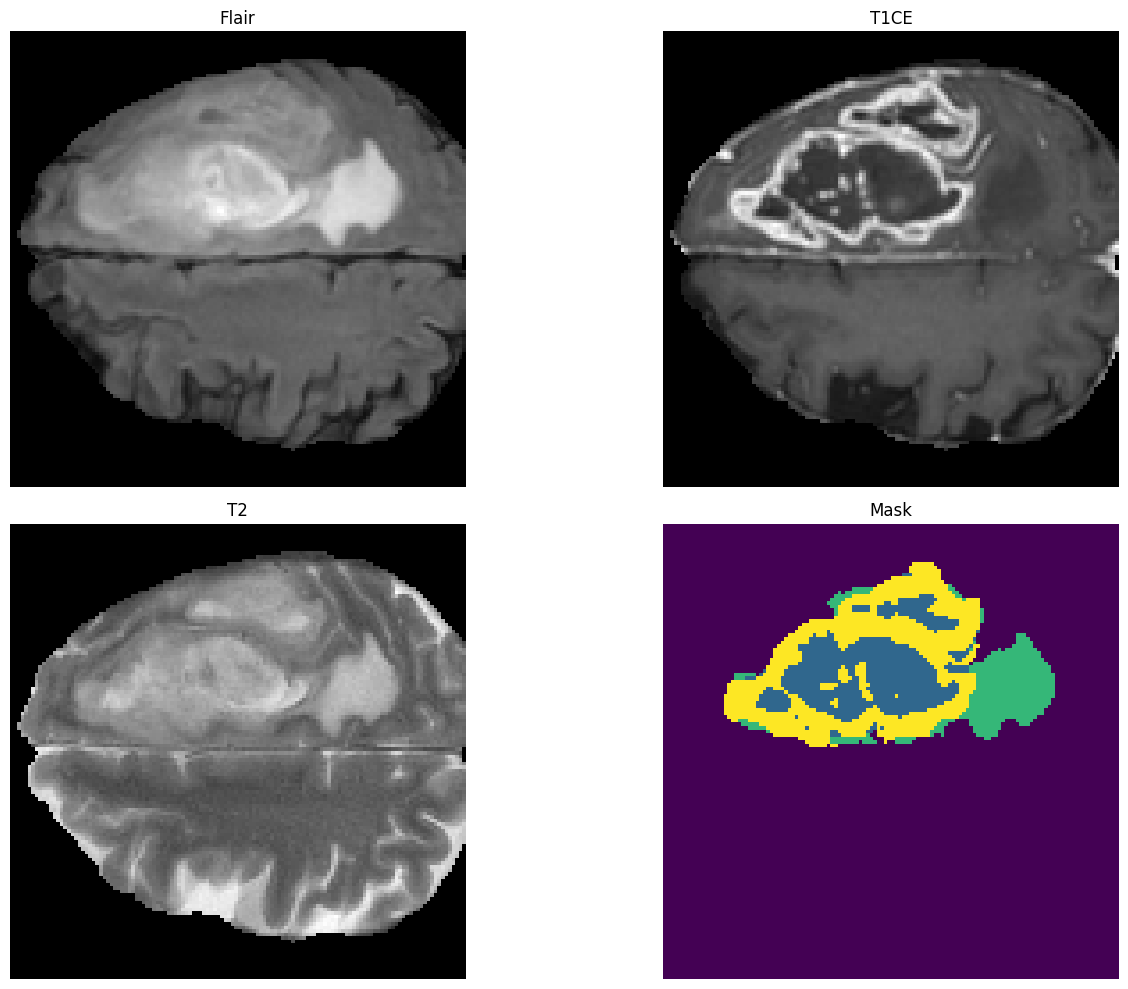

In [21]:
visualize_mri_slices(combined_x, test_mask, seed=0)

## Save and Load Processed Data

### Save Data

In [22]:
np.save("data/combined_x.npy", combined_x)

### Load and Verify Data

In [23]:
my_img = np.load("data/combined_x.npy")

In [24]:
np.array_equal(combined_x, my_img)

True

## Convert Segmentation Mask to Categorical
### Converts mask from shape `(H, W, D)` → `(H, W, D, num_classes)`, where `num_classes=4`.

In [25]:
test_mask = to_categorical(test_mask, num_classes=4)

In [26]:
test_mask.shape

(128, 128, 128, 4)